In [19]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
#import community 
from itertools import compress
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Load and clean data 

In [20]:
## read pre-processed data from stata
df = pd.read_stata('../data/0_CPIS_CDIS_BIS_USTIC_merged_fixed1.dta')
keep_var = ['countrycode','counterpart_code','country','counterpart','year','CDIS_IAD','CPIS_IAP','loans_dep']
df = df[keep_var]                           ## keep only used variables 
df = df.replace(np.nan,0)                   ## turn na to zero 
num = df._get_numeric_data()
num[num < 0] = 0                            ## turn negative to zero 
df['total'] = df[['CDIS_IAD','CPIS_IAP','loans_dep']].sum(axis=1)
#df.describe()

#### Create weights for edges 

In [21]:
mata = ['countrycode','counterpart_code','country','counterpart','year']
var_org = ['CDIS_IAD','CPIS_IAP','loans_dep','total']
var_sum_out = ['CDIS_Sum_out','CPIS_Sum_out','loans_dep_Sum_out','total_Sum_out']
var_sum_in = ['CDIS_Sum_in','CPIS_Sum_in','loans_dep_Sum_in','total_Sum_in']
var_weight = ['CDIS_weight','CPIS_weight','loans_dep_weight','total_weight']

df[var_sum_out]= df.groupby(['countrycode','year'])[var_org].transform(sum)           ## like stata egen sum 
df[var_sum_in]= df.groupby(['counterpart_code','year'])[var_org].transform(sum)        ## like stata egen sum 
df_weight = pd.DataFrame(df[var_org].values / df[var_sum_out].values,columns=[var_weight])
df[var_weight] = df_weight                                                        ## create the weight variables 
mata.extend(var_weight)
df = df[mata]
df.fillna(0,inplace=True)

#### Create centrality measure time series 

In [22]:
def merge_degree(degree_centrality,G,var,year):
    # Find nodes with highest degree, unweighted 
    k=G.degree(weight=var)                                 ## get the degree centrality for all countries 
    k = pd.DataFrame(list(k.items()),columns=['country',year])      ## make it into dataframe
    k.sort_values(by=year,ascending=0,inplace=True)                 ## sort it 
    if degree_centrality is None:
        degree_centrality = k
    else:
        degree_centrality = pd.merge(degree_centrality,k,on='country',how='outer')
    return degree_centrality

def merge_between(between_centrality,G,var,year):
    ## betweeness 
    b = nx.betweenness_centrality(G,weight=var)  # weight='total_weight'
    between = pd.DataFrame(list(b.items()),columns=['country',year])      ## make it into dataframe
    between.sort_values(by=year,ascending=0,inplace=True)    
    if between_centrality is None:
        between_centrality = between
    else:
        between_centrality = pd.merge(between_centrality,between,on='country',how='outer')
    return between_centrality

def merge_eigenvector(eigenvector_centrality,G,var,year):
    ## eigenvector centrality
    e = nx.eigenvector_centrality_numpy(G,weight=var)
    eigenvector = pd.DataFrame(list(e.items()),columns=['country',year])      ## make it into dataframe
    eigenvector.sort_values(by=year,ascending=0,inplace=True)    
    if eigenvector_centrality is None:
        eigenvector_centrality = eigenvector
    else:
        eigenvector_centrality = pd.merge(eigenvector_centrality,eigenvector,on ='country',how='outer')
    return eigenvector_centrality

def merge_closeness(closeness_centrality,G,var,year):
    ## closeness centrality
    c=nx.closeness_centrality(G,distance =var )
    closeness = pd.DataFrame(list(c.items()),columns=['country',year])      ## make it into dataframe
    closeness.sort_values(by=year,ascending=0,inplace=True)   
    if closeness_centrality is None:
        closeness_centrality = closeness
    else:
        closeness_centrality = pd.merge(closeness_centrality,closeness,on ='country',how='outer')
    return closeness_centrality

def merge_local_cluster_coef(local_cluster,G,var,year):
    ## local cluster coefficient
    ud_G = to_undirected(G)
    lc=nx.clustering(G=ud_G,weight = 'weight')                           ## after changing to un_directed, weight name changed to weeight
    lc_df = pd.DataFrame(list(lc.items()),columns=['country',year])      ## make it into dataframe
    lc_df.sort_values(by=year,ascending=0,inplace=True)   
    if local_cluster is None:
        local_cluster = lc_df
    else:
        local_cluster = pd.merge(local_cluster,lc_df,on ='country',how='outer')
    return local_cluster

def to_undirected(G):
    node_list = G.nodes()
    node_list.sort()
    A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight=var)
    ud_M = A + A.T 
    ud_G = nx.from_numpy_matrix(ud_M)
    ## relable node to country name 
    maplist = dict(zip(ud_G.nodes(), node_list))
    ud_G = nx.relabel_nodes(ud_G,maplist)
    return ud_G

def plot_top_n(centrality,n):
    top10 = centrality.ix[0:n]
    top10.index = top10.country
    top10.drop(labels='country',axis=1,inplace=True)
    top10.T.sort_index().plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def export_to_excel(name):
    writer = pd.ExcelWriter(name+'.xlsx', engine='xlsxwriter')
    degree_centrality.to_excel(writer, sheet_name='degree')
    between_centrality.to_excel(writer, sheet_name='between')
    eigenvector_centrality.to_excel(writer, sheet_name='eigenvector')
    closeness_centrality.to_excel(writer,sheet_name = 'closeness')
    local_cluster.to_excel(writer,sheet_name = 'cluster')
    writer.save()

### General statistics 

In [23]:
var_weight = ['CDIS_weight','CPIS_weight','loans_dep_weight','total_weight']

for var in var_weight:
    #var = 'total_weight'
    var_dist = 'distance'
    degree_centrality = None
    between_centrality = None
    eigenvector_centrality = None
    closeness_centrality = None
    local_cluster = None
    
    for year in range(2009,2016):
        df_graph = df[(df['year']==year) & (df[var]>0)]
        df_graph[var_dist] = 1-df_graph[var]
        G = nx.from_pandas_dataframe(df_graph, source="country", target="counterpart", edge_attr=[var,var_dist],create_using=nx.DiGraph())
        degree_centrality =  merge_degree(degree_centrality,G,var,year)
        between_centrality = merge_between(between_centrality,G,var_dist,year)       ## not weighted 
        eigenvector_centrality = merge_eigenvector(eigenvector_centrality,G,var,year)
        closeness_centrality = merge_closeness(closeness_centrality,G,var_dist,year) ## use distance measure
        local_cluster = merge_local_cluster_coef(local_cluster,G,var,year)
    ## exoprt to 
    export_to_excel('../result/excel/'+var)

### Visualize

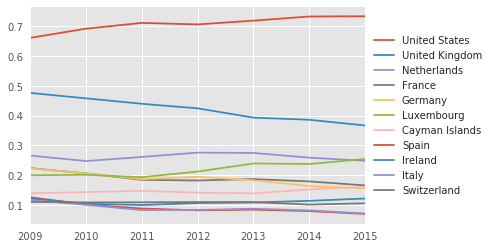

In [24]:
plot_top_n(eigenvector_centrality,10)

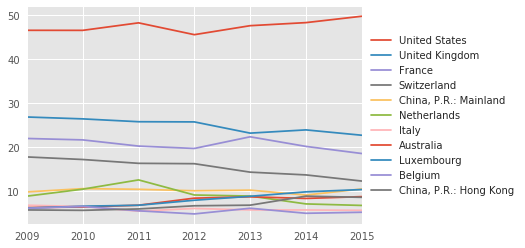

In [25]:
plot_top_n(degree_centrality,10)

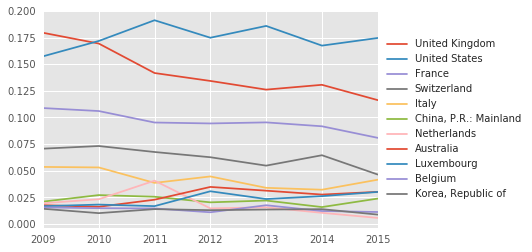

In [26]:
plot_top_n(between_centrality,10)

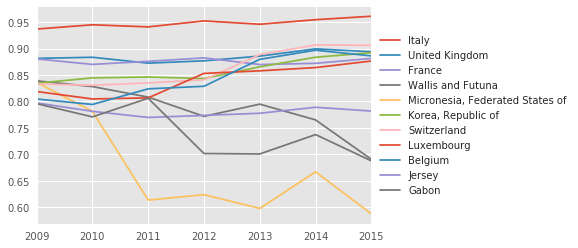

In [27]:
plot_top_n(closeness_centrality,10)